In [1]:
import os
import gc
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import ConcatDataset, random_split, DataLoader
from Datasets import *

SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)

# Optional (for reproducibility in CUDA):
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
# plot train and evaluation loss over iterations. option to specifiy first plotted iteration
def plot_train_eval_loss(train_loss_path, eval_loss_path, start_iteration = 0):
    train_loss_arr = np.load(train_loss_path) # array of noise pred loss values
    eval_loss_table = np.load(eval_loss_path) # table of iteration, noise pred loss, reconstruction loss

    train_x = np.arange(0, len(train_loss_arr))
    train_noise_pred_loss = train_loss_arr

    eval_x = eval_loss_table[:, 0].astype(int)
    eval_noise_pred_loss = eval_loss_table[:, 1]
    eval_reconstruction_loss = eval_loss_table[:, 2]

    if start_iteration > 0:
      mask_train = train_x >= start_iteration
      mask_eval = eval_x >= start_iteration

      train_x = train_x[mask_train]
      train_noise_pred_loss = train_noise_pred_loss[mask_train]

      eval_x = eval_x[mask_eval]
      eval_noise_pred_loss = eval_noise_pred_loss[mask_eval]
      eval_reconstruction_loss = eval_reconstruction_loss[mask_eval]
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_x, train_noise_pred_loss, label='Train Noise Pred Loss', linewidth=1)
    plt.plot(eval_x, eval_noise_pred_loss, label='Eval Noise Pred Loss', linewidth=1)
    plt.plot(eval_x, eval_reconstruction_loss, label='Eval Reconstruction Loss', linewidth=1)
    plt.xlabel('Train Iteration')
    plt.ylabel('Avg. Loss')
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.title('Train Iteration vs Avg. Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [3]:
# Setup the device to be used for training and evaluation
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    x = torch.ones(1, device=DEVICE)
    print("Using CUDA device.")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    x = torch.ones(1, device=DEVICE)
    print("Using Apple Metal Performance Shaders (MPS) device.")
else:
    DEVICE = torch.device("cpu")
    print("No GPU found. Defaulting to CPU.")

RGB_LATENT_PATHS = [
  'data/one_meter_naip/224final_naip_latent_dataset_drone_V1_512.npy'
]
SATELLITE_LATENT_PATHS = [
  'data/one_meter_naip/224final_naip_latent_dataset_satellite_V1_512.npy'
]

INTERVAL = 100 # number of reconstruction time intervals
NUM_ITR = 1002 # number of train iterations
BATCH_SIZE = 1024
LR = 4e-4

Using Apple Metal Performance Shaders (MPS) device.


# Config

In [4]:
from utils import JupyterArgParser
from pathlib import Path

# ========= global settings =========
# Taken from i2sb paper with minor changes

RESULT_DIR = Path("results")

# --------------- basic ---------------
parser = JupyterArgParser()
parser.add_argument("--seed",           type=int,   default=0)
parser.add_argument("--name",           type=str,   default=None,        help="experiment ID")
parser.add_argument("--ckpt",           type=str,   default=None,        help="resumed checkpoint name")
parser.add_argument("--device",         type=str,   default=DEVICE,      help="type of device to use for training")
parser.add_argument("--gpu",            type=int,   default=None,        help="set only if you wish to run on a particular GPU")

# --------------- model ---------------
parser.add_argument("--image-size",     type=int,   default=224)
parser.add_argument("--t0",             type=float, default=1e-4,        help="sigma start time in network parametrization")
parser.add_argument("--T",              type=float, default=1.,          help="sigma end time in network parametrization")
parser.add_argument("--interval",       type=int,   default=INTERVAL,        help="number of interval")
parser.add_argument("--beta-max",       type=float, default=0.3,         help="max diffusion for the diffusion model")
parser.add_argument("--beta-schedule",  type=str,   default="i2sb",    help="schedule for beta")
parser.add_argument("--ot-ode",         action="store_true",             help="use OT-ODE model")
parser.add_argument("--clip-denoise",   action="store_true",             help="clamp predicted image to [-1,1] at each")
parser.add_argument("--use-fp16",       action="store_true",             help="use fp16 for training")
parser.add_argument("diffusion-type",   type=str,   default="schrodinger_bridge",      help="type of diffusion model")

# --------------- optimizer and loss ---------------
parser.add_argument("--batch-size",     type=int,   default=BATCH_SIZE)
parser.add_argument("--microbatch",     type=int,   default=4,           help="accumulate gradient over microbatch until full batch-size")
parser.add_argument("--num-itr",        type=int,   default=NUM_ITR,     help="training iteration")
parser.add_argument("--lr",             type=float, default=LR,        help="learning rate")
parser.add_argument("--lr-gamma",       type=float, default=0.99,        help="learning rate decay ratio")
parser.add_argument("--lr-step",        type=int,   default=1000,        help="learning rate decay step size")
parser.add_argument("--l2-norm",        type=float, default=0.0)
parser.add_argument("--ema",            type=float, default=0.99)

# --------------- path and logging ---------------
parser.add_argument("--dataset-dir",    type=Path,  default="/dataset",  help="path to LMDB dataset")
parser.add_argument("--log-dir",        type=Path,  default=".log",      help="path to log std outputs and writer data")
parser.add_argument("--log-writer",     type=str,   default=None,        help="log writer: can be tensorbard, wandb, or None")
parser.add_argument("--wandb-api-key",  type=str,   default=None,        help="unique API key of your W&B account; see https://wandb.ai/authorize")
parser.add_argument("--wandb-user",     type=str,   default=None,        help="user name of your W&B account")
parser.add_argument("--ckpt-path",      type=Path,  default=None,        help="path to save checkpoints")
parser.add_argument("--load",           type=Path,  default=None,        help="path to load checkpoints")
parser.add_argument("--unet_path",      type=str,   default=None,        help="path of UNet model to load for training")

# --------------- distributed ---------------
parser.add_argument("--local-rank",     type=int,   default=0)
parser.add_argument("--global-rank",    type=int,   default=0)
parser.add_argument("--global-size",    type=int,   default=1)

opt = parser.get_options()
# ========= path handle =========
opt.name = "test"
os.makedirs(opt.log_dir, exist_ok=True)
opt.ckpt_path = RESULT_DIR / opt.name if opt.name else RESULT_DIR / "temp"
os.makedirs(opt.ckpt_path, exist_ok=True)

if opt.ckpt:
    ckpt_file = RESULT_DIR / opt.ckpt / "latest.pt"
    assert ckpt_file.exists()
    opt.load = ckpt_file
else:
    opt.load = None

# ========= auto assert =========
assert opt.batch_size % opt.microbatch == 0, f"{opt.batch_size=} is not dividable by {opt.microbatch}!"



# Prepare Data

In [5]:
# Dataset creation from list of npy files

subdatasets = []

for hr_f, lr_f in zip(RGB_LATENT_PATHS, SATELLITE_LATENT_PATHS):
  hr_mem = np.load(hr_f, mmap_mode='r')
  lr_mem = np.load(lr_f, mmap_mode='r')
  subdatasets.append(
    LatentSpaceDataset(hr_mem, lr_mem, transform=None)
  )

full_dataset = ConcatDataset(subdatasets) # wrapper that routes indices to sub-datasets
full_length = len(full_dataset)
print(f"Combined dataset has length={full_length}")
n_train = int(0.9*full_length)
n_val = full_length - n_train

train, val = random_split(
    full_dataset,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(1234)
) # returns 2 subset objects. each subset object holds list of indices into full

print(f"Train dataset length: {len(train)}. Evaluate dataset length:{len(val)}")

Combined dataset has length=45540
Train dataset length: 40986. Evaluate dataset length:4554


In [6]:
from i2sb.runner import Runner

# build runner
run = Runner(opt)
# print(run.net)

# for sanity, freeze all layer weights of run.net except for diffusion layer
for name, param in run.net.named_parameters():
    if not name.startswith('diffuser.'):
        param.requires_grad = False

# check trainable parameters
for name, param in run.net.named_parameters():
    print(f"{name:40s}  requires_grad={param.requires_grad}")


/Users/evanwu/ml-mangrove/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


dummy input: latent space channels=512
Built schrodinger_bridge Diffusion Model with 100 steps and i2sb beta schedule!
encoder.0.weight                          requires_grad=False
encoder.1.weight                          requires_grad=False
encoder.1.bias                            requires_grad=False
encoder.4.0.conv1.weight                  requires_grad=False
encoder.4.0.bn1.weight                    requires_grad=False
encoder.4.0.bn1.bias                      requires_grad=False
encoder.4.0.conv2.weight                  requires_grad=False
encoder.4.0.bn2.weight                    requires_grad=False
encoder.4.0.bn2.bias                      requires_grad=False
encoder.4.1.conv1.weight                  requires_grad=False
encoder.4.1.bn1.weight                    requires_grad=False
encoder.4.1.bn1.bias                      requires_grad=False
encoder.4.1.conv2.weight                  requires_grad=False
encoder.4.1.bn2.weight                    requires_grad=False
encoder.4.1.b

In [7]:
train_loss, eval_loss = run.train(opt, train, val)

train_inner_loop:   0%|          | 0/256 [00:00<?, ?it/s]/Users/evanwu/ml-mangrove/.venv/lib/python3.13/site-packages/torch/utils/data/_utils/collate.py:285: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:209.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
train_inner_loop: 100%|██████████| 256/256 [00:02<00:00, 103.69it/s]


train_it 1/1002 | lr:4.00e-04 | noise_prediction_loss:+1.5389
Saved weights and losses on iteration 0


eval_inner_loop: 100%|██████████| 256/256 [00:34<00:00,  7.38it/s]


EVALUATE: eval_it 1/1002 | noise_prediction_loss:+1.4775 | reconstruction_loss:+0.0886


train_inner_loop: 100%|██████████| 256/256 [00:02<00:00, 121.64it/s]


train_it 2/1002 | lr:4.00e-04 | noise_prediction_loss:+1.4699


train_inner_loop: 100%|██████████| 256/256 [00:02<00:00, 120.59it/s]


train_it 3/1002 | lr:4.00e-04 | noise_prediction_loss:+0.6968


train_inner_loop: 100%|██████████| 256/256 [00:02<00:00, 121.24it/s]


train_it 4/1002 | lr:4.00e-04 | noise_prediction_loss:+0.6271


train_inner_loop: 100%|██████████| 256/256 [00:02<00:00, 122.46it/s]


train_it 5/1002 | lr:4.00e-04 | noise_prediction_loss:+0.6181


train_inner_loop: 100%|██████████| 256/256 [00:02<00:00, 115.19it/s]


train_it 6/1002 | lr:4.00e-04 | noise_prediction_loss:+0.6151


train_inner_loop: 100%|██████████| 256/256 [00:02<00:00, 124.90it/s]


train_it 7/1002 | lr:4.00e-04 | noise_prediction_loss:+0.5927


train_inner_loop: 100%|██████████| 256/256 [00:02<00:00, 123.26it/s]


train_it 8/1002 | lr:4.00e-04 | noise_prediction_loss:+0.6098


train_inner_loop: 100%|██████████| 256/256 [00:02<00:00, 122.52it/s]


train_it 9/1002 | lr:4.00e-04 | noise_prediction_loss:+0.6147


train_inner_loop: 100%|██████████| 256/256 [00:02<00:00, 125.24it/s]


train_it 10/1002 | lr:4.00e-04 | noise_prediction_loss:+0.6091


train_inner_loop: 100%|██████████| 256/256 [00:03<00:00, 65.78it/s]


train_it 51/1002 | lr:4.00e-04 | noise_prediction_loss:+0.5898


train_inner_loop: 100%|██████████| 256/256 [00:03<00:00, 80.62it/s]


train_it 101/1002 | lr:4.00e-04 | noise_prediction_loss:+0.5820


train_inner_loop: 100%|██████████| 256/256 [00:04<00:00, 56.00it/s]


train_it 151/1002 | lr:4.00e-04 | noise_prediction_loss:+0.5740


train_inner_loop: 100%|██████████| 256/256 [00:03<00:00, 76.45it/s]


train_it 201/1002 | lr:4.00e-04 | noise_prediction_loss:+0.5689


eval_inner_loop: 100%|██████████| 256/256 [00:59<00:00,  4.34it/s]


EVALUATE: eval_it 201/1002 | noise_prediction_loss:+0.5719 | reconstruction_loss:+0.0073


train_inner_loop: 100%|██████████| 256/256 [00:03<00:00, 73.54it/s]


train_it 251/1002 | lr:4.00e-04 | noise_prediction_loss:+0.5810


train_inner_loop: 100%|██████████| 256/256 [00:05<00:00, 49.69it/s]


train_it 301/1002 | lr:4.00e-04 | noise_prediction_loss:+0.5578


train_inner_loop: 100%|██████████| 256/256 [00:04<00:00, 63.65it/s]


train_it 351/1002 | lr:4.00e-04 | noise_prediction_loss:+0.5498


train_inner_loop: 100%|██████████| 256/256 [00:04<00:00, 59.95it/s]


train_it 401/1002 | lr:4.00e-04 | noise_prediction_loss:+0.5609


eval_inner_loop: 100%|██████████| 256/256 [01:15<00:00,  3.41it/s]


EVALUATE: eval_it 401/1002 | noise_prediction_loss:+0.5565 | reconstruction_loss:+0.0066


train_inner_loop: 100%|██████████| 256/256 [00:04<00:00, 61.12it/s]


train_it 451/1002 | lr:4.00e-04 | noise_prediction_loss:+0.5687


train_inner_loop: 100%|██████████| 256/256 [00:04<00:00, 63.83it/s]


train_it 501/1002 | lr:4.00e-04 | noise_prediction_loss:+0.5690


train_inner_loop: 100%|██████████| 256/256 [00:04<00:00, 54.09it/s]


train_it 551/1002 | lr:4.00e-04 | noise_prediction_loss:+0.5529


train_inner_loop: 100%|██████████| 256/256 [00:06<00:00, 40.92it/s]


train_it 601/1002 | lr:4.00e-04 | noise_prediction_loss:+0.5653


eval_inner_loop: 100%|██████████| 256/256 [01:27<00:00,  2.94it/s]


EVALUATE: eval_it 601/1002 | noise_prediction_loss:+0.5511 | reconstruction_loss:+0.0068


train_inner_loop: 100%|██████████| 256/256 [00:04<00:00, 63.22it/s]


train_it 651/1002 | lr:4.00e-04 | noise_prediction_loss:+0.5521


train_inner_loop: 100%|██████████| 256/256 [00:04<00:00, 61.21it/s]


train_it 701/1002 | lr:4.00e-04 | noise_prediction_loss:+0.5600


train_inner_loop: 100%|██████████| 256/256 [00:04<00:00, 59.38it/s]


train_it 751/1002 | lr:4.00e-04 | noise_prediction_loss:+0.5675


train_inner_loop: 100%|██████████| 256/256 [00:04<00:00, 60.81it/s]


train_it 801/1002 | lr:4.00e-04 | noise_prediction_loss:+0.5434


eval_inner_loop: 100%|██████████| 256/256 [01:13<00:00,  3.47it/s]


EVALUATE: eval_it 801/1002 | noise_prediction_loss:+0.5606 | reconstruction_loss:+0.0065


train_inner_loop: 100%|██████████| 256/256 [00:03<00:00, 74.30it/s]


train_it 851/1002 | lr:4.00e-04 | noise_prediction_loss:+0.5477


train_inner_loop: 100%|██████████| 256/256 [00:04<00:00, 55.67it/s]


train_it 901/1002 | lr:4.00e-04 | noise_prediction_loss:+0.5674


train_inner_loop: 100%|██████████| 256/256 [00:04<00:00, 59.27it/s]


train_it 951/1002 | lr:4.00e-04 | noise_prediction_loss:+0.5429


train_inner_loop: 100%|██████████| 256/256 [00:03<00:00, 66.48it/s]


train_it 1001/1002 | lr:3.96e-04 | noise_prediction_loss:+0.5592
Saved weights and losses on iteration 1000


eval_inner_loop: 100%|██████████| 256/256 [01:08<00:00,  3.73it/s]


EVALUATE: eval_it 1001/1002 | noise_prediction_loss:+0.5544 | reconstruction_loss:+0.0064
Saved weights and losses on iteration 1001


In [8]:
# t_noise_pred_l = np.load('results/test/train_losses.npy')
# ti = np.arange(0, len(t_noise_pred_l))

# e = np.load('results/test/eval_losses.npy')
# ei = e[:, 0].astype(int)
# e_noise_pred_l = e[:, 1]
# e_reconstruction_l = e[:, 2]

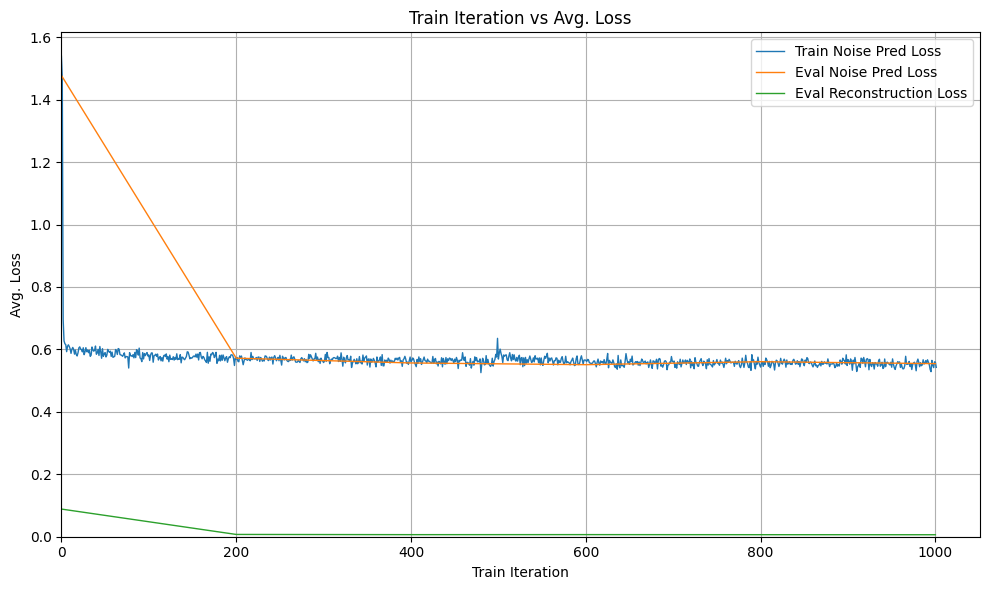

In [9]:
plot_train_eval_loss(train_loss_path='results/test/train_losses.npy', eval_loss_path='results/test/eval_losses.npy', start_iteration = 0)

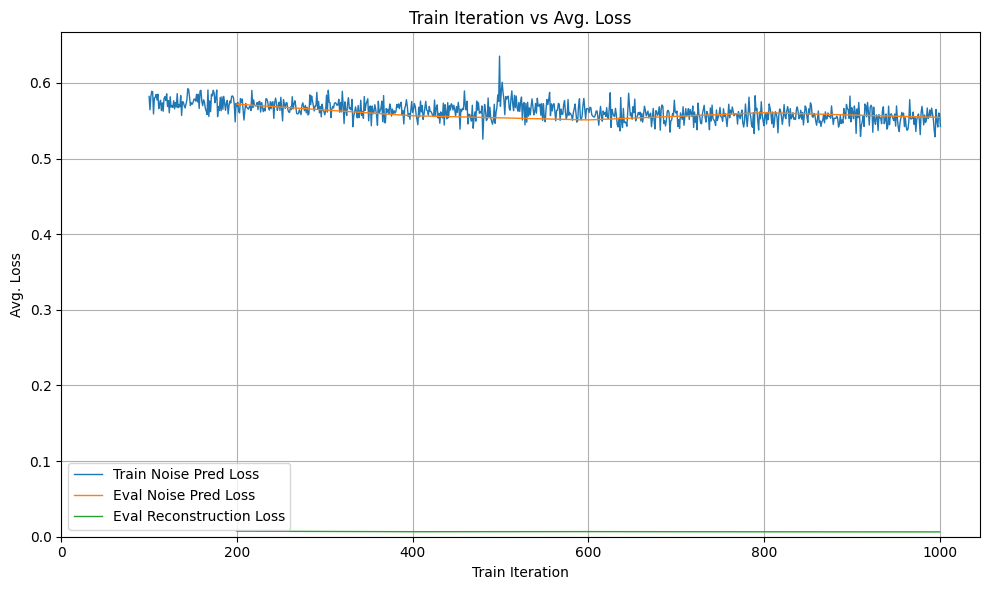

In [10]:
plot_train_eval_loss(train_loss_path='results/test/train_losses.npy', eval_loss_path='results/test/eval_losses.npy', start_iteration = 100)